### Importing libraries

In [2]:
from ultralytics import YOLO
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r"C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

### Read image

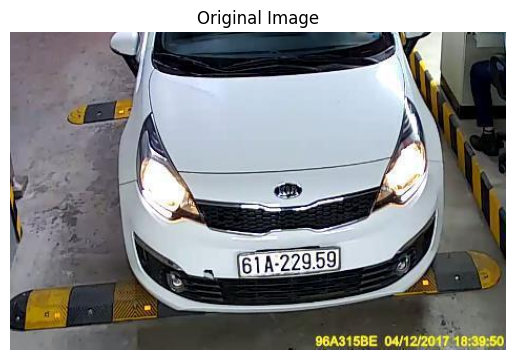

In [3]:
img = cv2.imread("car5.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

### Detecting the plate and draw boundary box


image 1/1 e:\programming\imgProcessLessonPro\car5.jpg: 416x640 1 License_Plate, 48.1ms
Speed: 12.0ms preprocess, 48.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


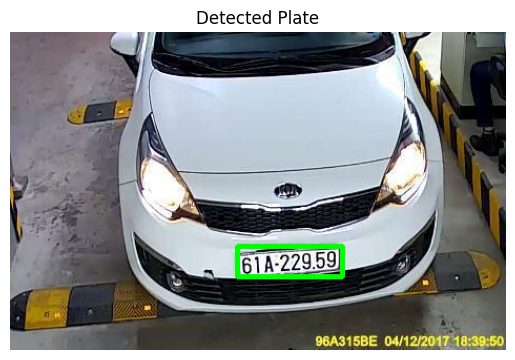

In [4]:
# Load YOLO model
model = YOLO("model\licensebest.pt")

# Predict
results = model("car5.jpg")[0]

# Extract bounding box 
boxes = results.boxes
if len(boxes) == 0:
    print("No plate detected!")
    raise SystemExit

# Take the first detected plate
bx = boxes.xyxy[0].cpu().numpy()
x1, y1, x2, y2 = bx.astype(int)

# Draw box
detected = img_rgb.copy()

cv2.rectangle(detected, (x1,y1), (x2,y2), (0,255,0), 3)

plt.imshow(detected)
plt.title("Detected Plate")
plt.axis("off")
plt.show()

### Crop plate region

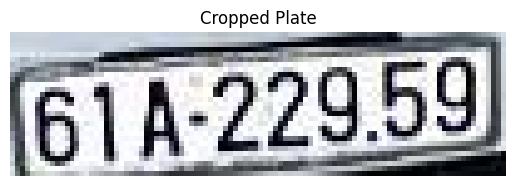

In [5]:
plate = img_rgb[y1:y2, x1:x2]

plt.imshow(plate)
plt.title("Cropped Plate")
plt.axis("off")
plt.show()

### Testing without preprocessing 

In [6]:
# OCR
text = pytesseract.image_to_string(
    plate,
    config='''--psm 7 -c tessedit_char_whitelist=
    ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'''
)
print("Detected Plate Number:", text.strip())

Detected Plate Number: 61 A-229.09,


### BT-709 and Luma Grayscale
#### Bt709 = 0.212 * B + 0.7154 * G + 0.072 * B
#### Luma = 0.3 * R + 0.59 * G + 0.11 * B

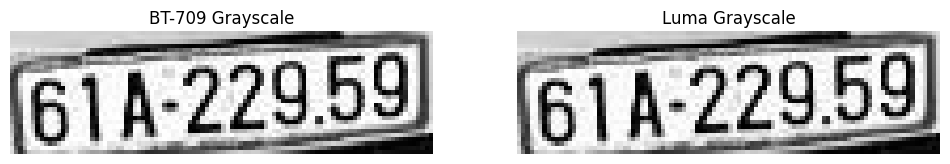

In [7]:
## BT-709
bt709 = 0.2125*plate[:,:,0] + 0.7154*plate[:,:,1] + 0.072*plate[:,:,2]
bt709 = bt709.astype(np.uint8)

## Luma
luma = 0.3*plate[:,:,0] + 0.59*plate[:,:,1] + 0.11*plate[:,:,2]
luma = luma.astype(np.uint8)

Param = [
    ("BT-709 Grayscale", bt709),
    ("Luma Grayscale", luma)
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (title, img) in zip(axes, Param):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis("off")
    
plt.show()

### Histogram before streaching and equelization

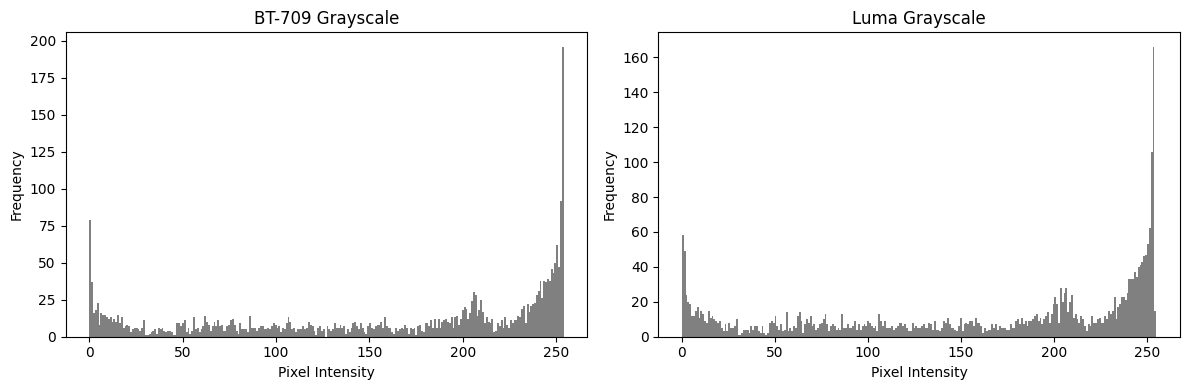

In [8]:
histParam = [
    ("BT-709 Grayscale", bt709),
    ("Luma Grayscale", luma)
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (title, img) in zip(axes, histParam):
    ax.hist(img.flatten(), bins=256, color='gray')
    ax.set_title(title)
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [9]:
type(luma)
luma

array([[207, 208, 209, ..., 182, 207, 220],
       [205, 205, 207, ..., 106, 159, 212],
       [209, 209, 210, ...,  57, 113, 206],
       ...,
       [192,  64,  80, ...,  17,  16,  13],
       [225,  94,  36, ...,  23,   1,  10],
       [217, 116,  40, ...,   7,   7,   7]], shape=(29, 100), dtype=uint8)

### HISTOGRAM STRETCHING and EQUALIZATION
####  Stretched = Pinput − c *((𝑔𝑚𝑎𝑥 −𝑔𝑚𝑖𝑛)/𝑑 −𝑐 )+𝑔𝑚𝑖n
####  Equalized = L-1 * ∑j=0:r ​p(rj​)

In [10]:
c = np.min(luma)
d = np.max(luma)
(int(c), int(d))

(0, 255)

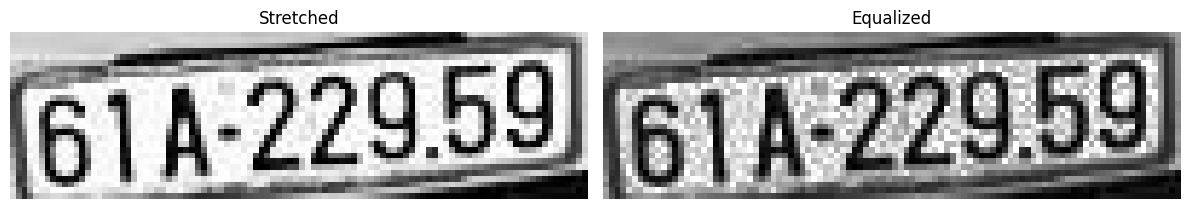

In [11]:
# Histogram stretching after we choosed luma
stretched = (luma - c) * (255 / (d - c))
stretched = stretched.astype(np.uint8)

# Histogram equalization
equalized = cv2.equalizeHist(luma)

histParam = [
    ("Stretched", stretched),
    ("Equalized", equalized)
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (title, img) in zip(axes, histParam):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()



### Showing the Histogram for each one after streaching and equelization

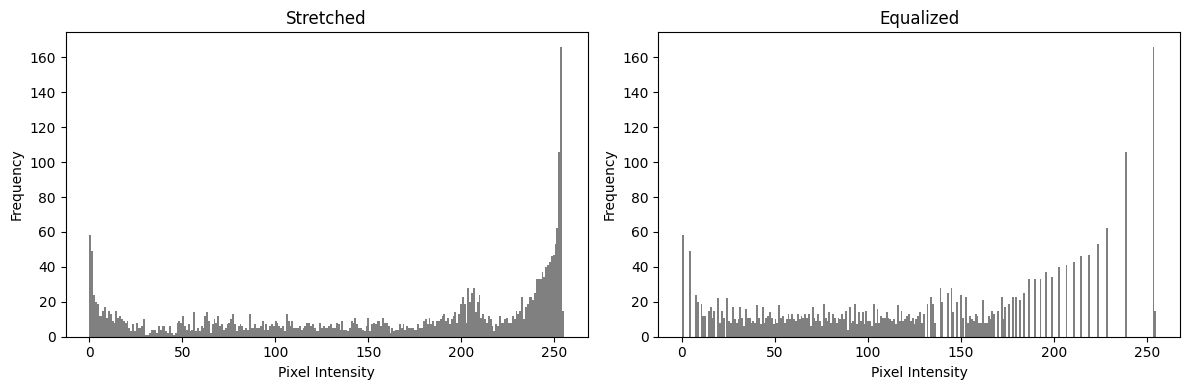

In [12]:
histParam = [
    ("Stretched", stretched),
    ("Equalized", equalized)
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (title, img) in zip(axes, histParam):
    ax.hist(img.flatten(), bins=256, color='gray')
    ax.set_title(title)
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


### Mean and median filtering 

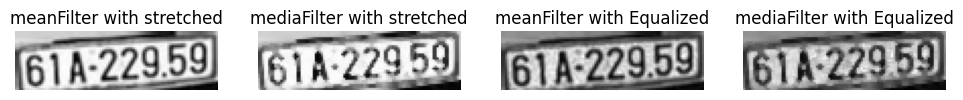

In [13]:
meanFilterStretched = cv2.blur(stretched,(2,2))
mediaFilterStretched = cv2.medianBlur(stretched,3)
meanFilterEqualized = cv2.blur(equalized,(2,2))
mediaFilterEqualized = cv2.medianBlur(equalized,3)
histParam = [
    ("meanFilter with stretched", meanFilterStretched),
    ("mediaFilter with stretched", mediaFilterStretched),
    ("meanFilter with Equalized", meanFilterEqualized),
    ("mediaFilter with Equalized", mediaFilterEqualized)
]


fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for ax, (title, img) in zip(axes, histParam):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.show()


### OTSU THRESHOLDING


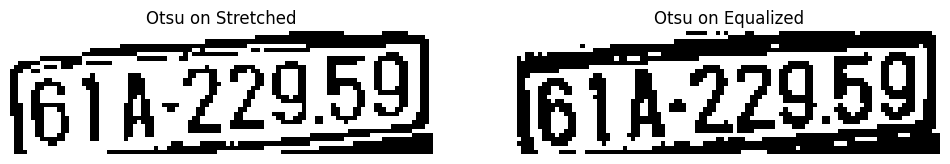

In [27]:
# Apply Otsu thresholding
_, otsuStretched  = cv2.threshold(stretched,  0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, otsuEqualized  = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

Param = [
    ("Otsu on Stretched", otsuStretched),
    ("Otsu on Equalized", otsuEqualized)
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (title, img) in zip(axes, Param):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis("off")


### Adaptive Threshold

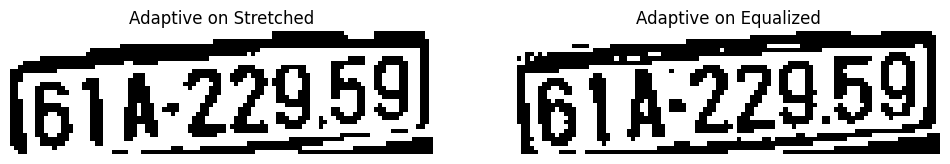

In [32]:
AdaptiveStreached = cv2.adaptiveThreshold(meanFilterStretched, 255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 35, 5)

AdaptiveEquelized  = cv2.adaptiveThreshold(equalized, 255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 35, 5)

Param = [
    ("Adaptive on Stretched", AdaptiveStreached),
    ("Adaptive on Equalized", AdaptiveEquelized)
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (title, img) in zip(axes, Param):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis("off")


### Reading the plate content

In [33]:
# OCR
textOtsuStretched = pytesseract.image_to_string(
    otsuStretched,
    config='--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
)
textOtsuEqualized = pytesseract.image_to_string(
    otsuEqualized,
    config='--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
)
textAdaptiveStreached = pytesseract.image_to_string(
    AdaptiveStreached,
    config='--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
)
textAdaptiveEquelized = pytesseract.image_to_string(
    AdaptiveEquelized,
    config='--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
)


print("Detected Plate Number with OtsuStreached:", textOtsuStretched.strip())
print("Detected Plate Number with otsuEqualized:", textOtsuEqualized.strip())
print("Detected Plate Number with AdaptiveStreached:", textAdaptiveStreached.strip())
print("Detected Plate Number with AdaptiveEquelized:", textAdaptiveEquelized.strip())

Detected Plate Number with OtsuStreached: G1A22959
Detected Plate Number with otsuEqualized: 61A22909
Detected Plate Number with AdaptiveStreached: 61A22959
Detected Plate Number with AdaptiveEquelized: 61A22959


### To avoid the misleading characters, you have to make some constraints 

In [17]:
import string

dict_char_to_int = {
    'O': '0',
    'I': '1',
    'J': '3',
    'A': '4',
    'G': '6',
    'S': '5',
    'T': '1'
}

dict_int_to_char = {
    '0': 'O',
    '1': 'I',
    '3': 'J',
    '4': 'A',
    '6': 'G',
    '5': 'S'
}


In [18]:
dict_int_to_char

{'0': 'O', '1': 'I', '3': 'J', '4': 'A', '6': 'G', '5': 'S'}

In [19]:
def fix_plate(text):    
    text = list(text)
    
    if text[2].isdigit() and text[2] in dict_int_to_char.keys():
        text[2] = dict_int_to_char[text[2]]

    number_indices = [0, 1, 3, 4, 5, 6]

    for i in number_indices:
        if text[i] in dict_char_to_int.keys():
            text[i] = dict_char_to_int[text[i]]

    return "".join(text)

In [20]:
text = fix_plate(text)
print("Detected Plate Number:", text.strip())

Detected Plate Number: 61 4-229.09,
